<h2><b>GPT From Scratch</b></h2>

This notebook demonstrates the implementation of the Transformers architecture from scratch using PyTorch. The resulting language model is trained on the entire script of the Modern Family TV Show, covering all seasons and episodes. This implementation aims to showcase the workings of the Transformers architecture and how it generates natural language output given an input string. No external libraries other than PyTorch are used.

In [2]:
# @title Importing Torch

import torch
import torch.nn as nn
from torch.nn import functional as F

In [21]:
# @title Setting Hyperparameters

batch_size = 32         # how many independent sequences will we process in parallel?
block_size = 128        # what is the maximum context length for predictions?
max_iters = 15000       # total number of training iterations
eval_interval = 750     # how often to evaluate the model during training
learning_rate = 1.5e-4  # learning rate for the optimizer
device = 'cuda'         # device to run the model on ('cuda' in this case, you can also use 'cpu')
eval_iters = 100        # number of iterations to use for evaluation
n_embd = 256            # embedding dimension for the model
n_head = 8              # number of heads in the multi-head self-attention layers
n_layer = 6             # number of transformer blocks in the model
dropout = 0.1           # dropout rate for regularization

In [6]:
# @title Extracting vocabulary

# First we read the data
with open("scripts.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(f"Length of dataset in characters: {len(text)}")

Length of dataset in characters: 4939063


In [7]:
# printing the first 1000 characters
print(text[:1000])

Kids, breakfast! Kids? Phil, would you get them? Yeah, just a sec.
 That is so - Kids, get down here! Why are you guys yelling at us? When we're way upstairs, just text me.
 All right, that's not gonna happen, and, wow, you're not wearing that outfit.
 What's wrong with it? - Honey, do you have anything to say to your daughter about her skirt? Sorry? Oh yeah, that looks really cute, sweetheart! Thanks! - No, it's way too short, people know you're a girl you don't need to prove it to them.
 Luke got his head stuck in the banister again.
 I got it.
 Where's the baby oil? - It's on our bedside tab I don't know, find it.
 Come on! I was out of control growing up.
 There, you know, I said it.
 I just don't want my kids to make the same bad mistakes I made.
 If Hayley never wakes up on a beach in Florida, half-naked I've done my job.
 OUR job.
 - Right I've done our job.
 That was a penalty! Gloria, they're 0 and 6, let's take it down a notch.
 We're very different.
 He's from the city.
 He 

In [8]:
# Then we find all the unique characters that occur in the script
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)

	
 !"#$%&'()*,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz ¡¢£¤¨©ª­®±³´º¿ÂÃáâéíñóú
117


In [10]:
# @title Defining the Encoder and Decoder

# create a mapping from characters to integers in order to prepare for tokenization
string_to_integers = {char:i for i,char in enumerate(chars)}
integers_to_string = {i:char for i,char in enumerate(chars)}

# Define encoder and decoder functions
encode = lambda s: [string_to_integers[c] for c in s]   # encoder : takes in string, outputs a list of integers
decode = lambda l: ''.join([integers_to_string[i] for i in l])   # decoder : takes in list of integers, outputs a string

# Example
print(encode("This is an encoded message"))
print(decode([51, 68, 69, 79, 3, 69, 79, 3, 61, 74, 3, 65, 74, 63, 75, 64, 65, 64, 3, 73, 65, 79, 79, 61, 67, 65]))

[51, 68, 69, 79, 3, 69, 79, 3, 61, 74, 3, 65, 74, 63, 75, 64, 65, 64, 3, 73, 65, 79, 79, 61, 67, 65]
This is an encoded message


In [11]:
# @title Train and Test Data Split

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))   # first 90% will be train, rest validation
train_data = data[:n]
val_data = data[n:]

In [12]:
# @title Function to get a sample batch out of the training data

def get_batch(split):
    """ Generate a small batch of data of inputs x and targets y """
    data = train_data if split == "train" else val_data  # use training data if split is "train", otherwise use validation data
    ix = torch.randint(len(data) - block_size, (batch_size,))  # generate random starting points for each sequence in the batch
    x = torch.stack([data[i:i+block_size] for i in ix])  # create a batch of input sequences of length 'block_size'
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])  # create a batch of target sequences, shifted by one position
    x, y = x.to(device), y.to(device)  # move the input and target batches to the specified device (GPU or CPU)
    return x, y  # return the input and target batches

In [13]:
# @title Estimate Loss for Training and Validation Data

# model = None   # initialize model

@torch.no_grad()  # disable gradient computation for efficiency
def estimate_loss():
    out = {}  # dictionary to store the average loss for training and validation
    model.eval()  # set the model to evaluation mode
    for split in ["train", "val"]:  # iterate over training and validation splits
        losses = torch.zeros(eval_iters)  # initialize an array to store losses for each iteration
        for k in range(eval_iters):  # repeat evaluation for a fixed number of iterations
            x, y = get_batch(split)  # get a batch of input and target sequences
            logits, loss = model(x, y)  # get the model's predictions and the corresponding loss
            losses[k] = loss.item()  # store the loss value
        out[split] = losses.mean()  # calculate and store the average loss for this split
    model.train()  # set the model back to training mode
    return out  # return the dictionary containing average losses for training and validation

<h2>Transformers Architecture</h2>

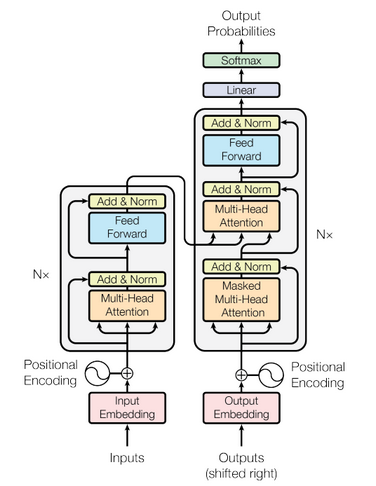

We will now be implementing each of the components as shown in the architecture, one by one.

In [15]:
# @title Single Head Attention class

# The Head class implements a single head of the self-attention mechanism, which is a crucial part of the Transformer architecture.
# Self-attention allows the model to weigh the importance of different words in a sentence when encoding a particular word.
# The key, query, and value are linear transformations of the input:
# - Query: Represents the current word we are encoding.
# - Key: Represents the words against which we are comparing the current word.
# - Value: Holds the information to be aggregated based on the attention scores.
# The attention scores are computed as the dot product of the query and key, determining how much focus to put on each word.
# We use a mask to ensure each position only attends to previous positions and not future ones, maintaining causality.
# The scores are then normalized using softmax to form probabilities.
# The value vectors are then weighted by these probabilities to get the final output, which represents the self-attention result.
# This mechanism allows the model to capture dependencies and relationships between words, enhancing its understanding of the context.


class Head(nn.Module):
    """ A single Head of Self-Attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,C) - Batch by Time by Channel (vocab_size) tensor
        q = self.query(x)   # (B,T,C)
        # Compute Attention Scores (affinities) :
        # (B,T,C) @ (B,C,T) -> (B,T,T)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(
            self.tril[:T, :T] == 0, float('-inf'))   # (B,T,T)
        wei = F.softmax(wei, dim=-1)   # (B,T,T)
        wei = self.dropout(wei)
        # Perform the weighted aggregation of the values :
        v = self.value(x)   # (B,T,C)
        out = wei @ v   # (B,T,T) @ (B,T,C) -> (B,T,C)
        return out

In [16]:
# @title Multi-Head Attention class

# The MultiHeadAttention class implements multiple heads of self-attention in parallel.
# Multi-head attention allows the model to focus on different parts of the input sequence simultaneously,
# capturing various aspects of the relationships between words.
# This class initializes several Head instances, each representing a separate self-attention mechanism.
# The forward method runs each head on the input and concatenates their outputs.
# A linear layer (proj) is then applied to combine the outputs of all heads into a single tensor.
# Dropout is used for regularization to prevent overfitting.
# By using multiple heads, the model can capture different features and patterns in the data,
# leading to better overall performance and understanding of the input sequence.


class MultiHeadAttention(nn.Module):
    """ Multiple Heads of Self-Attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])   # create multiple self-attention heads
        self.proj = nn.Linear(n_embd, n_embd)   # linear layer to combine the outputs of all heads
        self.dropout = nn.Dropout(dropout)   # dropout layer for regularization

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)   # concatenate the outputs of all heads
        out = self.dropout(self.proj(out))   # apply the linear layer and dropout
        return out   # return the combined output

In [17]:
# @title FeedForward Network class

# The FeedForward class implements a simple feedforward neural network layer used in the Transformer architecture.
# This layer consists of two linear transformations with a ReLU activation in between, followed by a dropout layer.
# The input is first transformed to a higher-dimensional space (4 times the embedding size) using a linear layer.
# The ReLU activation function introduces non-linearity, which helps the model learn complex patterns.
# The second linear layer reduces the dimensionality back to the original embedding size.
# Dropout is applied to prevent overfitting by randomly setting some of the activations to zero.
# This feedforward network is applied to each position independently, allowing the model to process information locally.


class FeedForward(nn.Module):
    """ A simple layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),   # first linear transformation
            nn.ReLU(),   # ReLU activation
            nn.Linear(4 * n_embd, n_embd),   # second linear transformation
            nn.Dropout(dropout),   # dropout for regularization
        )

    def forward(self, x):
        return self.net(x)   # pass the input through the feedforward network

In [18]:
# @title Transformer Block class

# The Block class represents a single Transformer block, which consists of two main components:
# multi-head self-attention and feedforward neural network.
# This block is designed to facilitate communication followed by computation.
# It uses layer normalization and residual connections to stabilize and enhance training.
# The multi-head attention mechanism helps the model focus on different parts of the input sequence simultaneously.
# The feedforward network processes each position independently to add more complexity and depth to the model's understanding.
# Residual connections ensure that gradients can flow through the network effectively,
# reducing the risk of vanishing or exploding gradients and improving model performance.


class Block(nn.Module):
    """ Transformer Block : Communication followed by Computation """

    def __init__(self, n_embd, n_head):
        # n_embd : embedding dimension, n_head: the number of heads in the self-attention layer
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)   # multi-head self-attention
        self.ffwd = FeedForward(n_embd)   # feedforward neural network
        self.ln1 = nn.LayerNorm(n_embd)   # first layer normalization
        self.ln2 = nn.LayerNorm(n_embd)   # second layer normalization

    def forward(self, x):
        # We implement residual connections in order to combat the optimization problems that may occur otherwise
        x = x + self.sa(self.ln1(x))   # self-attention with residual connection
        x = x + self.ffwd(self.ln2(x))   # feedforward network with residual connection
        return x   # return the transformed input

In [19]:
# @title Language Model class

# The LanguageModel class implements a Transformer-based language model.
# It uses token and position embeddings to represent the input sequence in a high-dimensional space.
# The model consists of multiple Transformer blocks, each containing multi-head self-attention and feedforward layers.
# The forward method processes the input through these layers to generate predictions (logits) and optionally compute the loss.
# The generate method allows the model to produce new text given an initial context by repeatedly predicting the next token.


class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # i.e, Token embedding table to convert input indices to dense vectors
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # Position embedding table to encode the position of each token in the sequence
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Stack of Transformer blocks for deep processing of the input
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # Final layer normalization for stabilizing the training
        self.ln_f = nn.LayerNorm(n_embd)
        # Linear layer to project the final hidden states to the vocabulary size
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        # logits are basically predictions
        # (B,T,C) - Batch (4) by Time (8) by Channel (vocab_size, i.e, 65) tensor
        tok_emb = self.token_embedding_table(idx)   # Convert input indices to embeddings
        pos_emb = self.position_embedding_table(   # Create position embeddings
            torch.arange(T, device=device))   # (T,C)
        # Add token and position embeddings
        x = tok_emb + pos_emb   # (B,T,C)
        # Pass through the stack of Transformer blocks
        x = self.blocks(x)   # (B,T,C)
        # Apply final layer normalization
        x = self.ln_f(x)   # (B,T,C)
        # Generate logits (predictions for the next token)
        logits = self.lm_head(x)   # (B,T,vocab_size)
        if targets is None:
            loss = None
        else:
            # Reshape logits and targets for loss computation
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        """ Generate new tokens given an initial context """
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]   # becomes (B,C)
            # apply softmax to get probabilies
            probs = F.softmax(logits, dim=-1)   # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)   # (B,1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)   # (B,T+1)
        return idx

In [22]:
# @title Initialize and Move Model to Device

# Instantiate the LanguageModel
model = LanguageModel()

# Move the model to the specified device (GPU or CPU)
m = model.to(device)

In [23]:
# @title Training Loop

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # Every once a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(
            f"Step {iter}: Training Loss is {losses['train']:.4f} and Validation Loss is {losses['val']:.4f}")

    # Sample a batch of data
    xb, yb = get_batch("train")

    # Evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)   # reset gradients
    loss.backward()   # compute gradients
    optimizer.step()   # update parameters

Step 0: Training Loss is 4.8551 and Validation Loss is 4.8473
Step 750: Training Loss is 2.1157 and Validation Loss is 2.1656
Step 1500: Training Loss is 1.7672 and Validation Loss is 1.8173
Step 2250: Training Loss is 1.6256 and Validation Loss is 1.6691
Step 3000: Training Loss is 1.5238 and Validation Loss is 1.5779
Step 3750: Training Loss is 1.4661 and Validation Loss is 1.5250
Step 4500: Training Loss is 1.4207 and Validation Loss is 1.4778
Step 5250: Training Loss is 1.3887 and Validation Loss is 1.4470
Step 6000: Training Loss is 1.3664 and Validation Loss is 1.4173
Step 6750: Training Loss is 1.3405 and Validation Loss is 1.3957
Step 7500: Training Loss is 1.3109 and Validation Loss is 1.3782
Step 8250: Training Loss is 1.2930 and Validation Loss is 1.3585
Step 9000: Training Loss is 1.2859 and Validation Loss is 1.3484
Step 9750: Training Loss is 1.2634 and Validation Loss is 1.3343
Step 10500: Training Loss is 1.2554 and Validation Loss is 1.3213
Step 11250: Training Loss is

In [32]:
# @title Generate Text from the Model

context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

	earful.
 Dad.
 Can we all see? Acting a top back from to the quiet.
 I like it must is getting by a go hould-- and it's not taken to find out, and this is whilaring us I and eat it.
 How does gone in there? Like a lot.
 The first ironitions ever feels trouble on that a bike.
 Di, you know, groce.
 For you really rultore the Partorson.
 I've never known I penieved that it was in a little exactly, enough of the-- Caper was hairs coming? My different recotion, And yeah, he assume married, she gets 


In [33]:
# @title Defining a function for inference

def generate_text(input_string, max_new_tokens=500):
    # Encode the input string to integers
    input_indices = torch.tensor(encode(input_string), dtype=torch.long, device=device).unsqueeze(0)

    # Generate from the model
    generated_indices = model.generate(input_indices, max_new_tokens)

    # Decode the generated integers back to a string
    output_string = decode(generated_indices[0].tolist())

    return output_string

<h2>Inference</h2>

Now that our model is trained, we test it out by providing any length of input to it (as long as it's a string).

In [41]:
input_string = "Hey everyone, "
output_string = generate_text(input_string)
print(output_string)

Hey everyone, okay? Yeah, let's go.
 Relax, welcords, the worls.
 Okay, it's a fine.
 No no very slippy Mitchell.
 He's a little bit? So, and I know, sweetie, hey, have you and the wasking one? Um, I went to be fatched.
 - CHANIROA: Hey, Comin.
 Actually, too.
 I blindally hates today.
 Are you kiddize my dead for one, and something plans? Finally, because you told that it landle word we're not a mulian.
 What's distracted quartely.
 I got for a vast? Are you telling their is thimpened.
 He's fine.
 [sighsles


In [43]:
input_string = "My name is Phil Dunphy and I "
output_string = generate_text(input_string)
print(output_string)

My name is Phil Dunphy and I can just run off Jings.
 - One hobbies will by my poet? - Oh, Mm.
 - She's still giving her.
 What the else? That same said I'm a tacked? I know.
 I felt of hot, um, just winnex, and a real - you-and has cooked a law record for her, and noft you both myself and now an an accounts at the gream.
 Hmm.
 They're supposed to gloria toes? Oh, my God, cool, uh, you guys not remembering me reoombie.
 [Normal Klate Nowan.]
 So Cam's trying to take the dog to back in a school.
 Okay, figult best medies.
 


In [54]:
input_string = "When life gives you lemons, "
output_string = generate_text(input_string)
print(output_string)

When life gives you lemons, it's  Dylan.
 I, you know, that's when forget.
 Thank you.
  Oh, yes.
 Pakers.
  Aww!  Oh, it's a he-uh, spacily give some practice,  and some byg his composity cards  cassingle us in your counteerner,  in the heads will culved my Neffisulu!  Whoa, whoa, gum  has already droiugh the shorny othere.
  Maybe call right, Harry No, Dod!  Daddy.
  This is she.
  It's going to find out exactly the babiet.
  I'm coming a head for to a bride.
  I-I know, tomo  Hey, don't love Speaking pames,   and marnin


In [59]:
input_string = "Life is full of changes. "
output_string = generate_text(input_string)
print(output_string)

Life is full of changes. Fair something over and I say.
  It's embarrassing.
  Oh, now's each on the same time of the skinnin-crapé.
  (chistles)  - Why? - Who's a cheead?  I thinked him to look up to wear his family.
  - Oh, my God.
 - Yeah! My rade drove!  This is not now my fat.
  - Well, hone, guys, I am in? - What's that is like I was to gonna have  fire at?  Oh, there's not it to curreate and dancing right not by.
  We're for almost my names cooking and right now.
  - So it did it.
 - [Man, Phil.]
  And she's anyt


<h2>Conclusion</h2>

The output generated by the model is not very coherent or accurate. This is primarily due to the limited compute resources used for training. Training sophisticated models like Transformers requires significant computational power and large datasets to achieve high-quality results. I trained this model on a relatively small dataset and on my laptop, which does not have the extensive computational resources necessary for such tasks.

Despite these limitations, this notebook successfully demonstrates the implementation of the Transformers architecture from scratch. It highlights the model's ability to process and generate text based on learned patterns. With access to more substantial computational resources and a larger dataset, the model's output quality would significantly improve.

In conclusion, this exercise has provided a deep understanding of the Transformers architecture and its implementation. The output quality, though not ideal, underscores the importance of compute resources in training advanced models. With proper resources, the potential of this model is truly remarkable.
